# Virtual Library of Simulation Experiments:
## Test Functions and Datasets  Optimization Test Problems

Collection of datasets taken from https://www.sfu.ca/~ssurjano/optimization.html

In [137]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [138]:
%config InlineBackend.figure_format = "retina"

## GPJax

In [143]:
import jax
import optax
import distrax
import gpjax as gpx
import jaxkern as jk
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jaxutils import Dataset
from jax.config import config
from pprint import PrettyPrinter

**The posterior probability distribution**

$$
    f(x) \vert f(x_{1:n}) \sim \cal{N}(\mu_n(x), \sigma^2_n(x)),
$$

where
$$
\begin{aligned}
    \mu_n(x) &= \Sigma_0(x, x_{1:n}) \Sigma_0(x_{1:n}, x_{1:n})^{-1} (f(x_{1:n}) - \mu_0(x_{1:n}) + \mu_0(x_{1:n})\\
    \sigma^2_n(x) &= \Sigma_0(x, x) - \Sigma_0(x, x_{1:n}) \Sigma_0(x_{1:n}, x_{1:n})^{-1} \Sigma_0(x_{1:n}, x)
\end{aligned}
$$


* The posterior mean $\mu_n(x)$ is a weighted average between the prior $\mu_0(x)$ and an estimate based on the data $f(x_{1:n})$, with a weight that depends on the kernel
* The posterior variance $\sigma^2(x)$ is equal to the prior covariance less a term that corresponds to the variance removed by observing $f(x_{1:n})$.

In [167]:
%config InlineBackend.figure_format = "retina"
config.update("jax_enable_x64", True)
pp = PrettyPrinter(indent=4)

In [264]:
n = 10
noise = 0.0

key = jax.random.PRNGKey(3141)
x = jax.random.uniform(key=key, minval=-4.0, maxval=4.0, shape=(n,)).sort().reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jax.random.normal(key, shape=signal.shape) * noise

D = Dataset(X=x, y=y)

xtest = jnp.linspace(-4, 4, 500).reshape(-1, 1)
ytest = f(xtest)

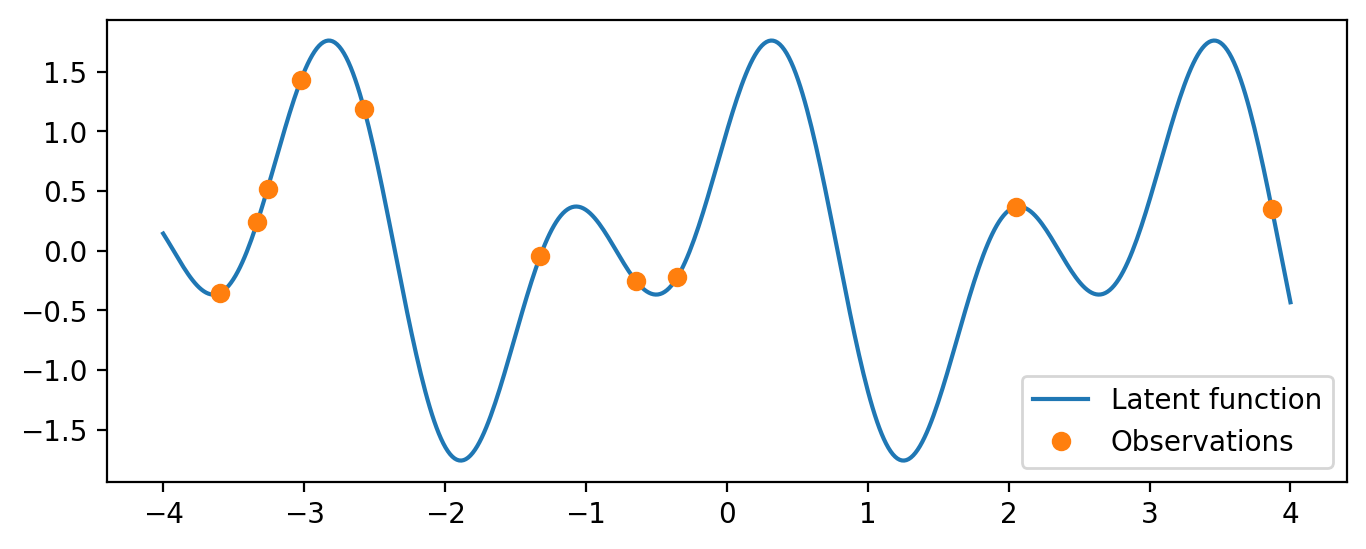

In [265]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(xtest, ytest, label="Latent function")
ax.plot(x, y, "o", label="Observations")
ax.legend(loc="best")

In [266]:
kernel = jk.RBF()
prior = gpx.Prior(kernel=kernel)

In [267]:
parameter_state = gpx.initialise(prior, key)
prior_dist = prior(parameter_state.params)(xtest)

prior_mean = prior_dist.mean()
prior_std = prior_dist.stddev()
samples = prior_dist.sample(seed=key, sample_shape=(20,)).T

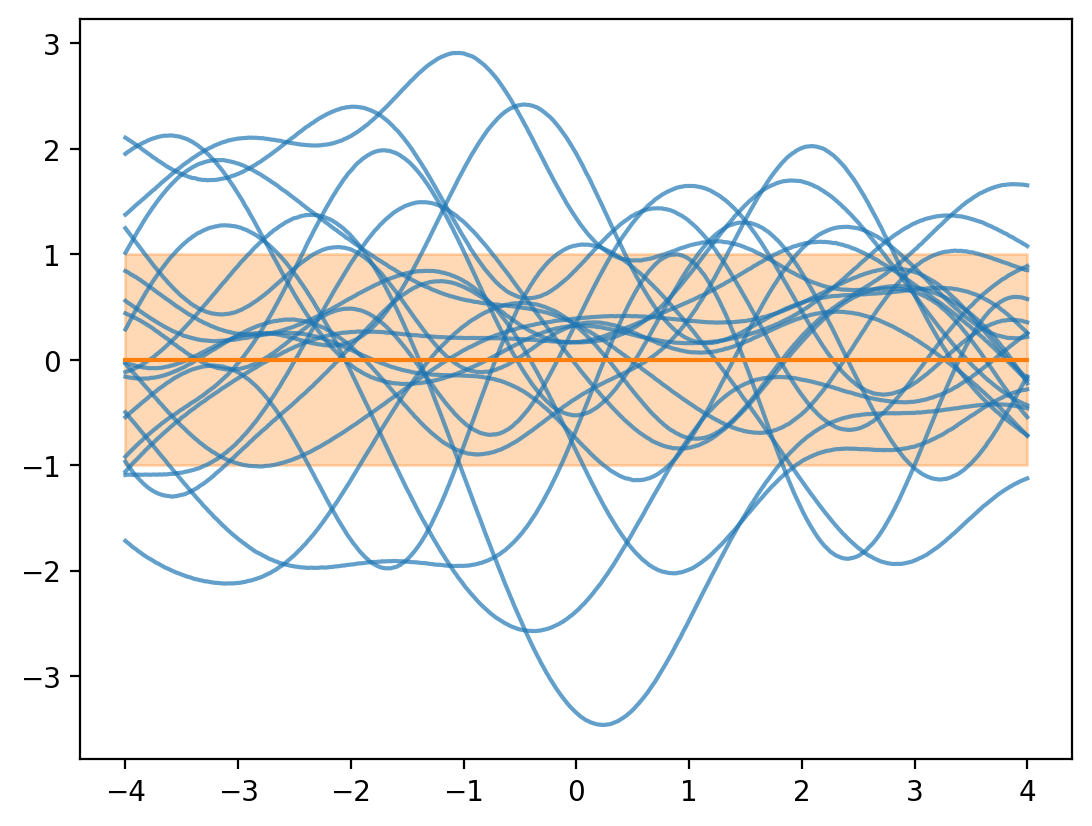

In [268]:
plt.plot(xtest, samples, color="tab:blue", alpha=0.7)
plt.plot(xtest, prior_mean, color="tab:orange")
plt.fill_between(
    xtest.flatten(),
    prior_mean - prior_std,
    prior_mean + prior_std,
    color="tab:orange",
    alpha=0.3,
)
plt.show()

In [149]:
likelihood = gpx.Gaussian(num_datapoints=D.n)
posterior = prior * likelihood

In [150]:
parameter_state = gpx.initialise(
    posterior, key, kernel={"lengthscale": jnp.array([0.1])}
)
print(type(parameter_state))

<class 'gpjax.parameters.ParameterState'>


In [13]:
params, trainable, bijectors = parameter_state.unpack()
pp.pprint(params)

{   'kernel': {   'lengthscale': Array([0.1], dtype=float64),
                  'variance': Array([1.], dtype=float64)},
    'likelihood': {'obs_noise': Array([1.], dtype=float64)},
    'mean_function': {}}


In [14]:
negative_mll = jax.jit(posterior.marginal_log_likelihood(D, negative=True))
negative_mll(params)

Array(13.62228709, dtype=float64)

In [15]:
optimiser = optax.adam(learning_rate=0.1)

inference_state = gpx.fit(
    objective=negative_mll,
    parameter_state=parameter_state,
    optax_optim=optimiser,
    num_iters=500,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 15044.02it/s, Objective=4.14]


In [16]:
learned_params, training_history = inference_state.unpack()
learned_params

{'kernel': {'lengthscale': Array([0.40517108], dtype=float64),
  'variance': Array([0.41003968], dtype=float64)},
 'likelihood': {'obs_noise': Array([4.78224531e-06], dtype=float64)},
 'mean_function': {}}

In [17]:
latent_dist = posterior(learned_params, D)(xtest)
predictive_dist = likelihood(learned_params, latent_dist)
predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

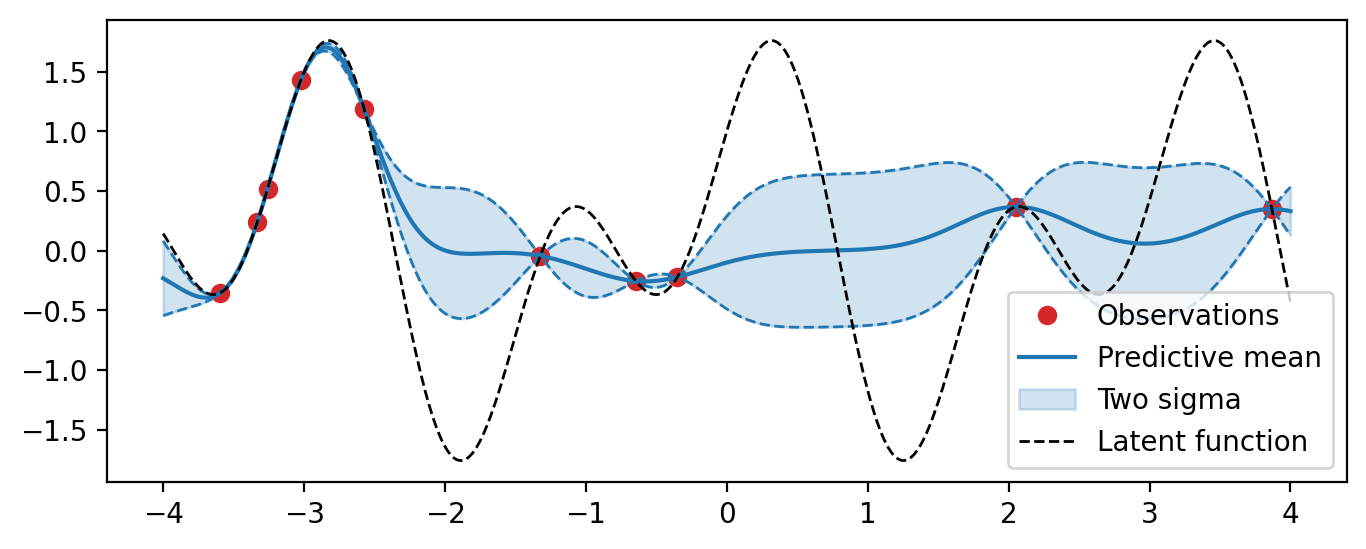

In [18]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(x, y, "o", label="Observations", color="tab:red")
ax.plot(xtest, predictive_mean, label="Predictive mean", color="tab:blue")
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - predictive_std,
    predictive_mean + predictive_std,
    alpha=0.2,
    color="tab:blue",
    label="Two sigma",
)

lbound = predictive_mean - predictive_std
ubound = predictive_mean + predictive_std

ax.plot(xtest, lbound, color="tab:blue", linestyle="--", linewidth=1)
ax.plot(xtest, ubound, color="tab:blue", linestyle="--", linewidth=1)
ax.plot(xtest, ytest, label="Latent function", color="black", linestyle="--", linewidth=1)

ax.legend()

## Prediction

In [19]:
init_params = dict(parameter_state.params)
init_params["kernel"]["lengthscale"] = 0.5
init_params["kernel"]["variance"] = 10.0
init_params["likelihood"]["obs_noise"] = 0.0

In [20]:
latent_dist = posterior(init_params, D)(xtest)
predictive_dist = likelihood(init_params, latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

In [21]:
predictive_dist.log_prob(jnp.array([0.4]))

Array(-1557345.12326198, dtype=float64)

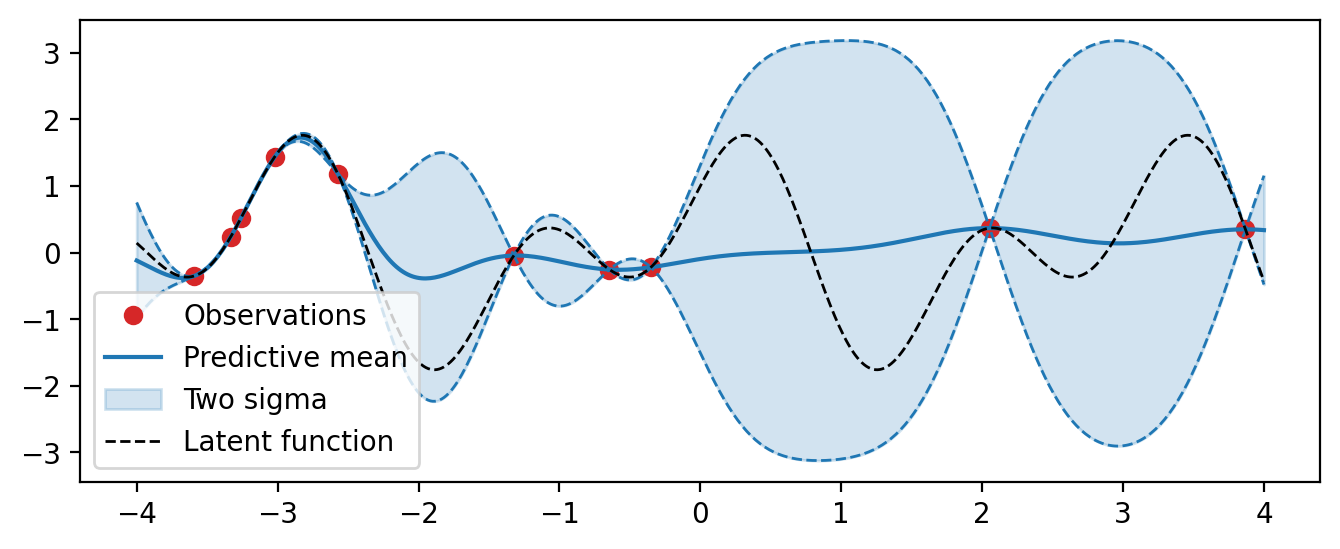

In [22]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(x, y, "o", label="Observations", color="tab:red")
ax.plot(xtest, predictive_mean, label="Predictive mean", color="tab:blue")
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - predictive_std,
    predictive_mean + predictive_std,
    alpha=0.2,
    color="tab:blue",
    label="Two sigma",
)

lbound = predictive_mean - predictive_std
ubound = predictive_mean + predictive_std

ax.plot(xtest, lbound, color="tab:blue", linestyle="--", linewidth=1)
ax.plot(xtest, ubound, color="tab:blue", linestyle="--", linewidth=1)
ax.plot(xtest, ytest, label="Latent function", color="black", linestyle="--", linewidth=1)

ax.legend()

## Expected improvement

$$
    \alpha_\text{EI}(x) = [\Delta_n(x)]^+ + \sigma_n(x) \varphi\left(\frac{\Delta_n(x)}{\sigma_n(x)}\right) - |\Delta_n(x)|\varPhi\left(\frac{\Delta_n(x)}{\sigma_n(x)}\right)
$$

In [141]:
distrax.Normal(0, 1).prob(0)

Array(0.39894228, dtype=float64)

In [108]:
@partial(jax.vmap, in_axes=(0, None))
@partial(jax.vmap, in_axes=(None, 0))
def eiv(delta, sigma):
    quotient = delta / sigma
    ndist = distrax.Normal(loc=0.0, scale=1.0)
    
    # ei = jnp.maximum(delta, 0.0) + sigma * ndist.prob(quotient) + jnp.abs(delta) * ndist.cdf(quotient)
    ei = sigma * ndist.prob(quotient) + delta * ndist.cdf(quotient)
    return ei

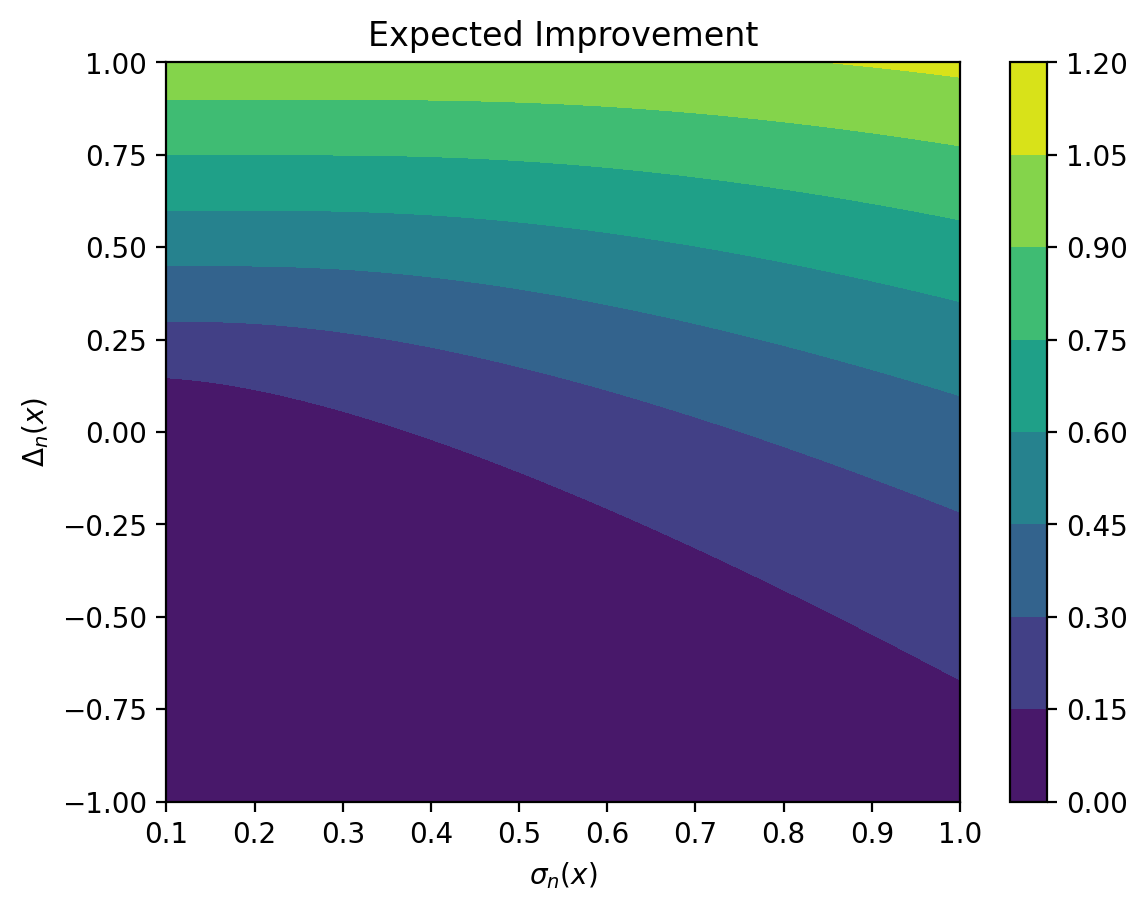

In [136]:
range_delta = jnp.linspace(-1, 1, 150)
range_sigma = jnp.linspace(0.1, 1, 160)

ei_map = eiv(range_delta, range_sigma)
X, Y = jnp.meshgrid(range_sigma, range_delta)

plt.contourf(X, Y, ei_map)
plt.xlabel("$\sigma_n(x)$")
plt.ylabel("$\Delta_n(x)$")
plt.colorbar()
plt.title("Expected Improvement");

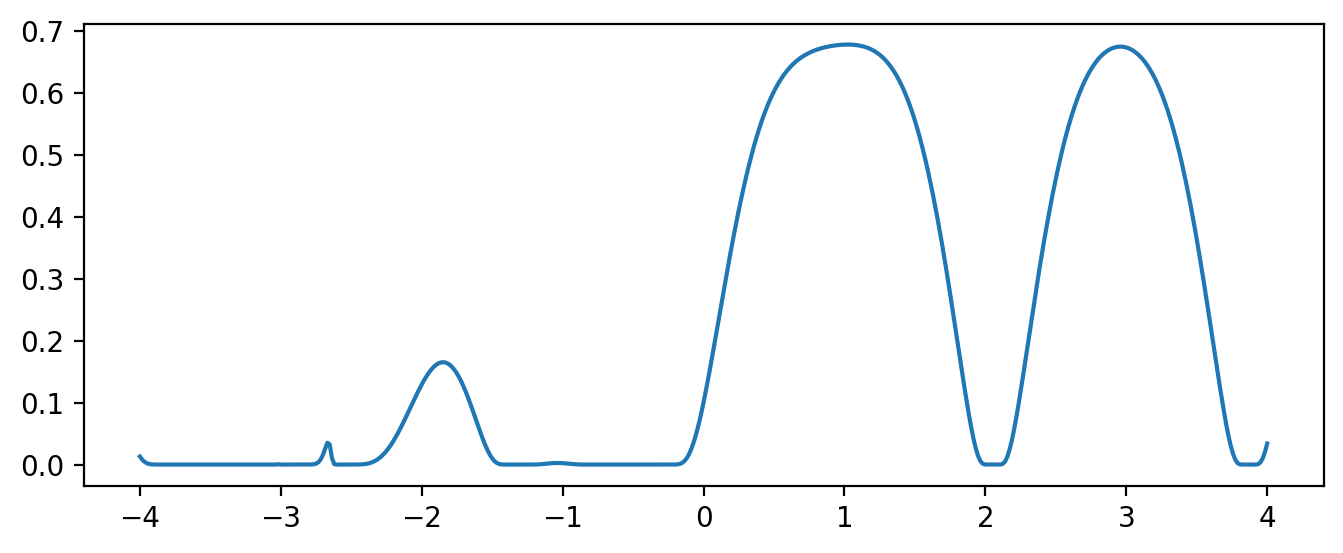

In [110]:
fig, ax = plt.subplots(figsize=(8, 3))

f_best = y.max()

latent_dist = posterior(init_params, D)(xtest)
predictive_dist = likelihood(learned_params, latent_dist)
predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

change_f = predictive_mean - f_best


ndist = distrax.Normal(0.0, 1.0)
quotient = change_f / predictive_std
phi_quot = ndist.prob(quotient)
Phi_quot = ndist.cdf(quotient)

ei = jnp.maximum(change_f, 0) + predictive_std * phi_quot - jnp.abs(change_f) * Phi_quot
plt.plot(xtest, ei)

In [133]:
def expected_improvement(x):
    latent_dist = posterior(init_params, D)(x)
    predictive_dist = likelihood(learned_params, latent_dist)
    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.stddev()
    
    f_best = y.max()
    change_f = predictive_mean - f_best

    ndist = distrax.Normal(0.0, 1.0)
    quotient = change_f / predictive_std
    phi_quot = ndist.prob(quotient)
    Phi_quot = ndist.cdf(quotient)

    # ei = jnp.maximum(change_f, 0.0) + predictive_std * phi_quot - jnp.abs(change_f) * Phi_quot
    ei = predictive_std * phi_quot + change_f * Phi_quot
    return ei.sum()


In [128]:
from jax.scipy.optimize import minimize
minimize(expected_improvement, jnp.array([0.2]), method="BFGS")

OptimizeResults(x=Array([1.02238945], dtype=float64), success=Array(True, dtype=bool), status=Array(0, dtype=int64, weak_type=True), fun=Array(-0.67798066, dtype=float64), jac=Array([5.95471136e-06], dtype=float64), hess_inv=Array([[2.49466585]], dtype=float64), nfev=Array(7, dtype=int64, weak_type=True), njev=Array(7, dtype=int64, weak_type=True), nit=Array(6, dtype=int64, weak_type=True))

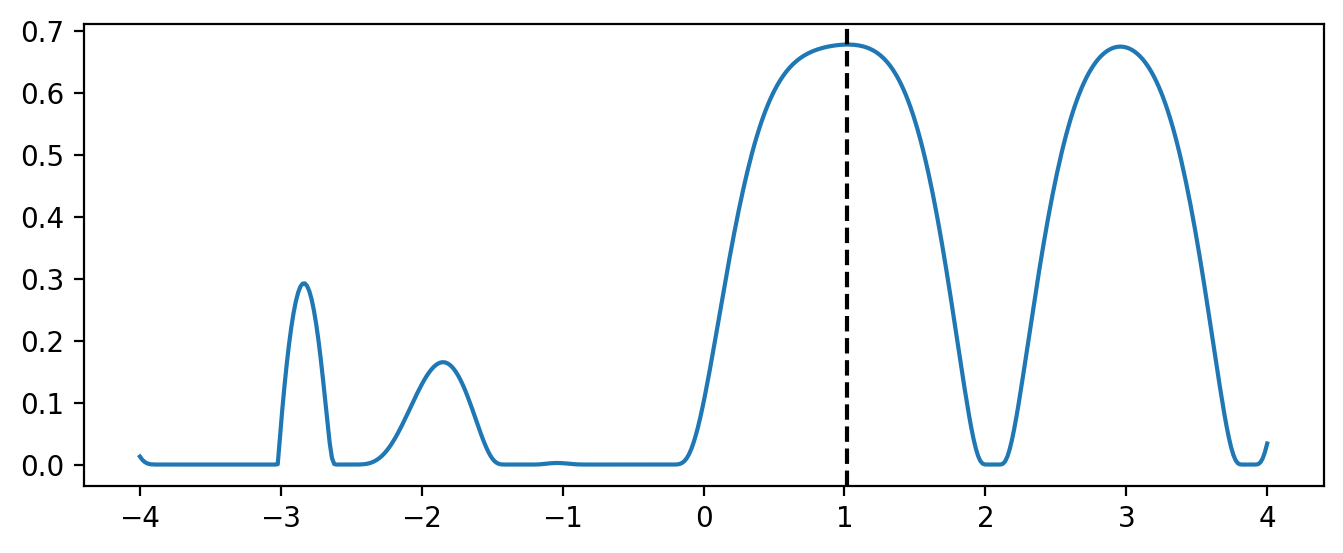

In [134]:
fig, ax = plt.subplots(figsize=(8, 3))

ei = jax.vmap(expected_improvement)(xtest)
ix_max = ei.argmax()
plt.plot(xtest, ei)
x_best = xtest[ix_max]
x_best = 1.02
plt.axvline(x=x_best, c="black", linestyle="--")

### Take next point

In [118]:
x_eval = xtest[ix_max]
x_next = jnp.concatenate([x, x_eval[:, None]])

y_next = jnp.concatenate([y.ravel(), f(x_eval)])[:, None]

In [664]:
# Concatenate new values
D_next = Dataset(X=x_next, y=y_next)

latent_dist = posterior(init_params, D_next)(xtest)
predictive_dist = likelihood(init_params, latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

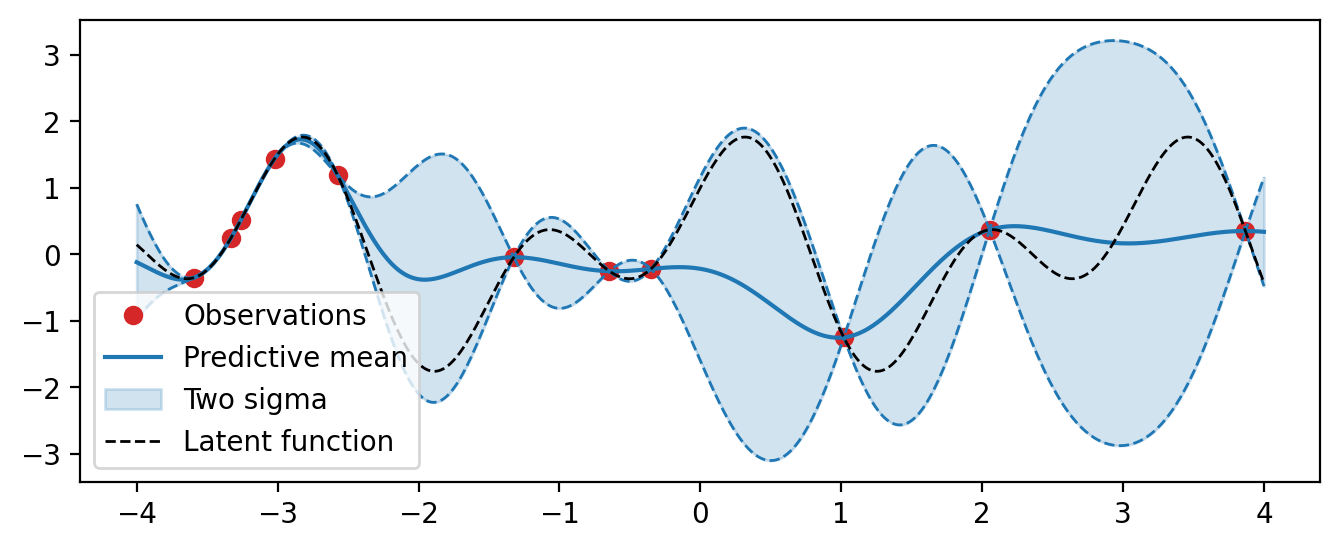

In [120]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(x_next, y_next, "o", label="Observations", color="tab:red")
ax.plot(xtest, predictive_mean, label="Predictive mean", color="tab:blue")
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - predictive_std,
    predictive_mean + predictive_std,
    alpha=0.2,
    color="tab:blue",
    label="Two sigma",
)

lbound = predictive_mean - predictive_std
ubound = predictive_mean + predictive_std

ax.plot(xtest, lbound, color="tab:blue", linestyle="--", linewidth=1)
ax.plot(xtest, ubound, color="tab:blue", linestyle="--", linewidth=1)
ax.plot(xtest, ytest, label="Latent function", color="black", linestyle="--", linewidth=1)

ax.legend()

# 2D example

In [843]:
def expected_improvement(x, D, params):
    posterior_dist = posterior(params, D)(x)
    predictive_dist = likelihood(params, posterior_dist)
    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.stddev()
    
    f_best = D.y.ravel().max()
    change_f = predictive_mean - f_best

    ndist = distrax.Normal(0.0, 1.0)
    quotient = change_f / predictive_std
    phi_quot = ndist.prob(quotient)
    Phi_quot = ndist.cdf(quotient)

    ei = predictive_std * phi_quot + change_f * Phi_quot
    return ei.sum()

## Branin dataset

In [816]:
@jax.jit
def branin(x1, x2):
    x1 = 15 * x1 - 5
    x2 = 15 * x2
    
    v1 = x2 - 5.2 * x1 ** 2 / (4 * jnp.pi ** 2) + 5 * x1 / jnp.pi - 6
    v2 = (10 - 10 / (8 * jnp.pi)) * jnp.cos(x1)
    v = (v1 ** 2 + v2 - 44.81) / 51.95
    return v

In [817]:
domain = jnp.mgrid[0:1:0.01, 0:1:0.01]
X1, X2 = domain
domain = jnp.linspace(0, 1, 100)

branin_xmap = jax.vmap(branin, (0, None))
branin_xmap = jax.vmap(branin_xmap, (None, 0))
Z = branin_xmap(domain, domain)

In [818]:
n = 5
noise = 0.0

key = jax.random.PRNGKey(31415)
x = jax.random.uniform(key=key, minval=0.0, maxval=1.0, shape=(n, 2))
y = jax.vmap(branin)(*x.T)[..., None]
D = Dataset(X=x, y=y)

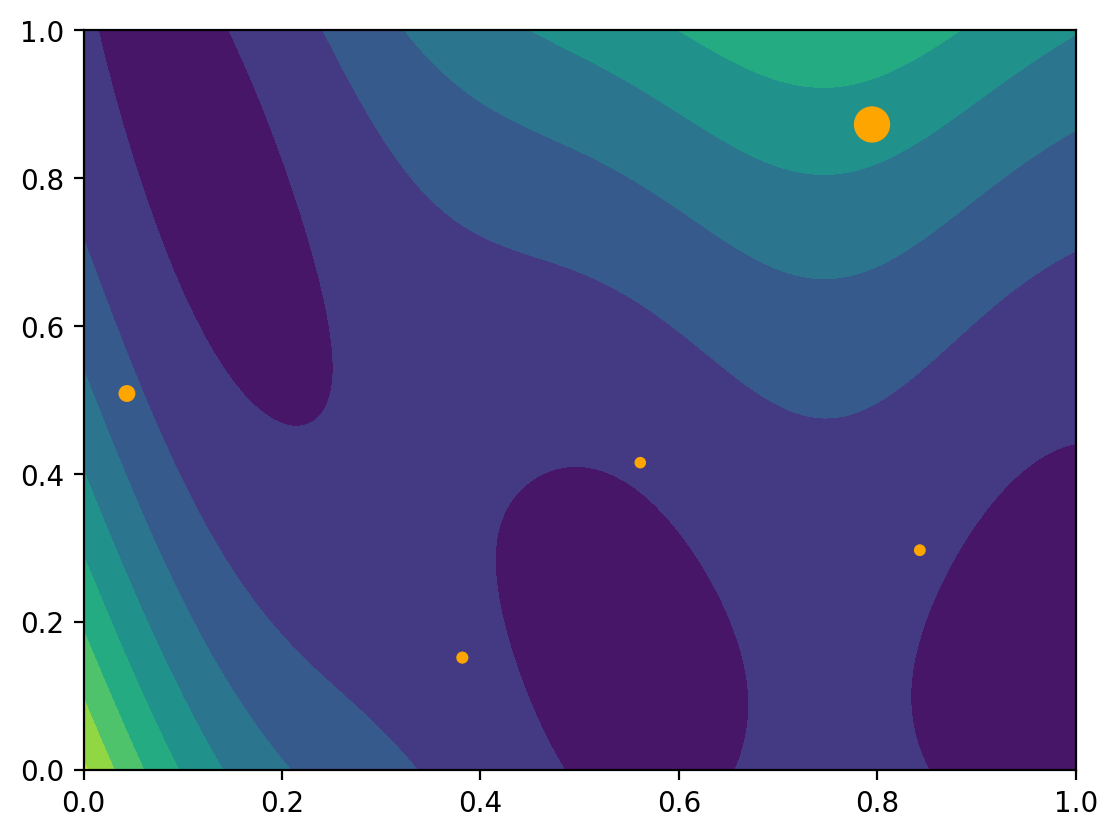

In [819]:
plt.contourf(domain, domain, Z, cmap="viridis")

size = 10 * jnp.exp(y - y.min())
plt.scatter(*D.X.T, s=size, c="orange")

### Model specification

In [845]:
kernel = jk.RBF()
prior = gpx.Prior(kernel=kernel)

In [921]:
vmax = 1
step = 0.02
pslice = slice(0, vmax + step, step)
xtest_grid = jnp.mgrid[pslice, pslice]
_, nd1, nd2 = xtest_grid.shape
xtest = einops.rearrange(xtest_grid, "dim width height -> (width height) dim")

In [977]:
kernel = jk.RBF()
prior = gpx.Prior(kernel=kernel)
likelihood = gpx.Gaussian(num_datapoints=D.n)

posterior = prior * likelihood

parameter_state = gpx.initialise(
    posterior, key,
    kernel={"lengthscale": 0.5},
    likelihood={"obs_noise": 0.0}
)

init_params = dict(parameter_state.params)

In [978]:
posterior_dist = posterior(init_params, D)(xtest)
predictive_dist = likelihood(init_params, posterior_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

Text(0.5, 1.0, 'Posterior predictive — GP')

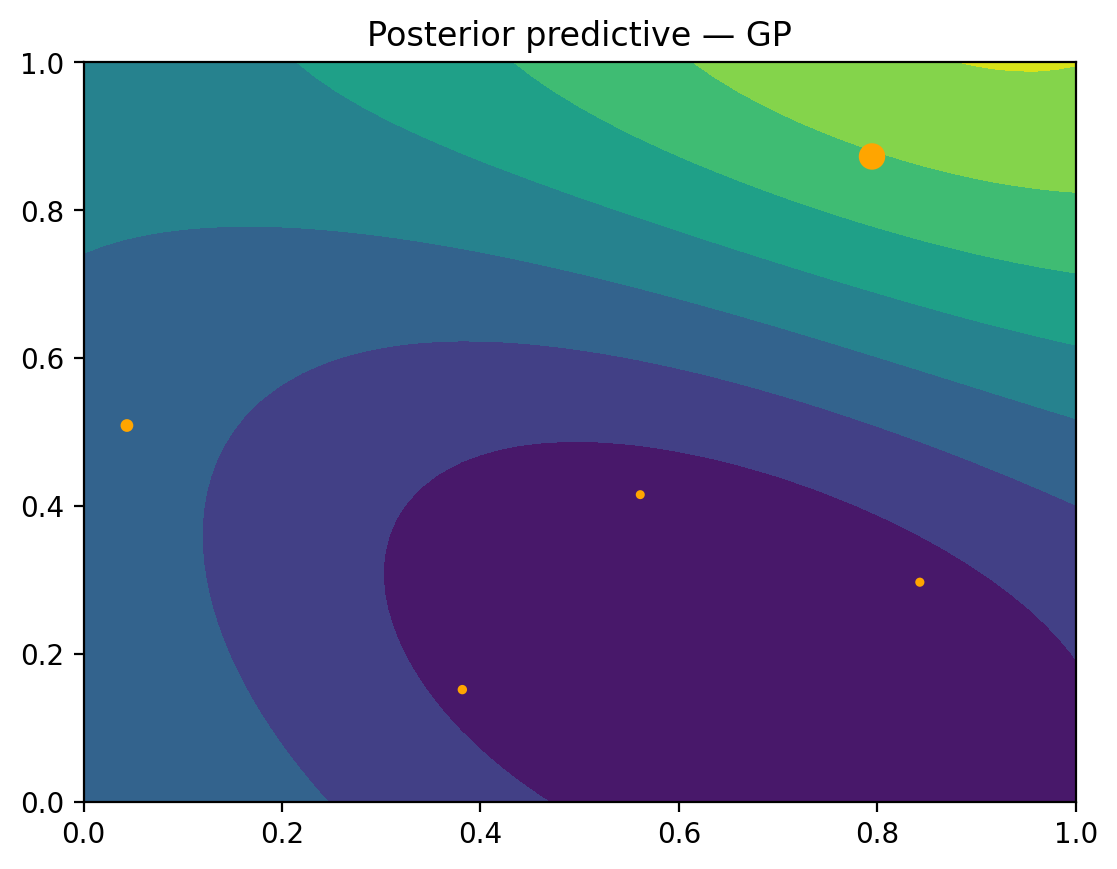

In [979]:
pm_grid  = einops.rearrange(predictive_mean, "(width height) -> width height", width=nd1)
plt.contourf(*xtest_grid, pm_grid)

size = 5 * jnp.exp(D.y - D.y.min())
plt.scatter(*D.X.T, s=size, c="orange")
plt.title("Posterior predictive — GP")

### Expected improvement

### Take next point

In [980]:
# Evaluate function over candidate points
ei_xtest = jax.vmap(expected_improvement, in_axes=(0, None, None))(xtest, D, init_params)
ei_grid = einops.rearrange(ei_xtest, "(width height) -> width height", width=nd1)

In [981]:
# Select index with maxium value
ix_max = ei_xtest.argmax()

# EI value
ei_xtest[ix_max]

# Position and function evaluation
x_next = xtest[ix_max]
y_next = branin(*x_next)

# Update dataset
x_new = jnp.concatenate([x, x_next[None]])
y_new = jnp.append(y.ravel(), y_next)[:, None]

D_next = Dataset(X=x_new, y=y_new)

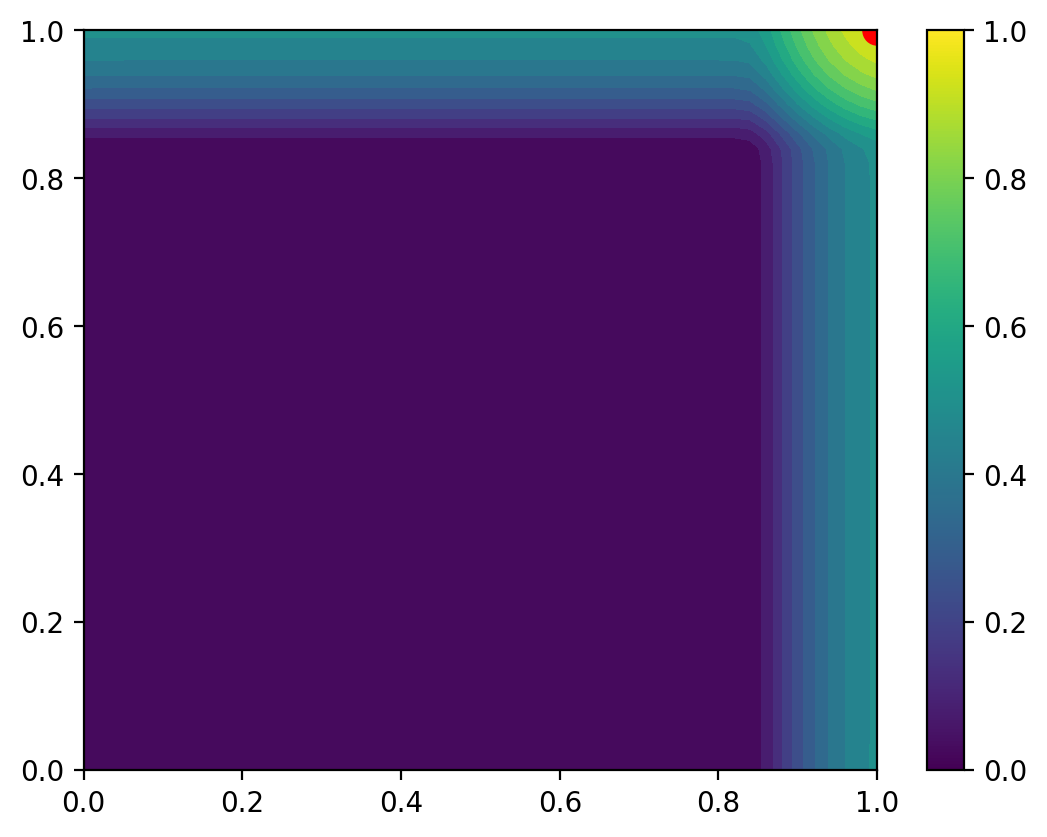

In [982]:
plt.contourf(*xtest_grid, ei_grid, levels=20)
plt.scatter(*x_next, c="red", s=100)
plt.colorbar()

In [983]:
# Update GP
latent_dist = posterior(init_params, D_next)(xtest)
predictive_dist = likelihood(init_params, latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

Text(0.5, 1.0, 'Posterior predictive — GP')

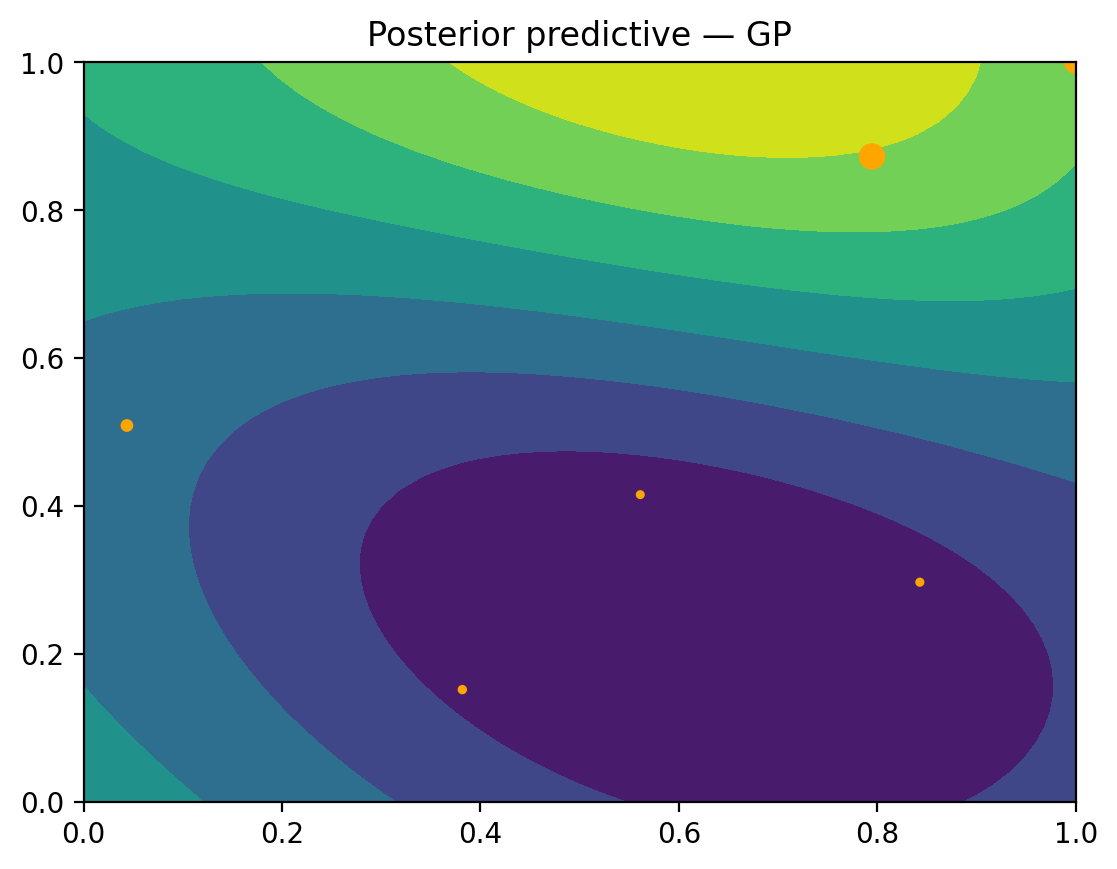

In [984]:
pm_grid = einops.rearrange(predictive_mean, "(width height) -> width height", width=nd1)
plt.contourf(*xtest_grid, pm_grid)

size = 5 * jnp.exp(D_next.y - D_next.y.min())
plt.scatter(*D_next.X.T, s=size, c="orange")
plt.title("Posterior predictive — GP")

In [985]:
# Evaluate function over candidate points
ei_xtest = jax.vmap(expected_improvement, in_axes=(0, None, None))(xtest, D_next, init_params)
ei_grid = einops.rearrange(ei_xtest, "(width height) -> width height", width=nd1)

In [986]:
# Select index with maxium value
ix_max = ei_xtest.argmax()

# EI value
ei_xtest[ix_max]

# Position and function evaluation
x_next = xtest[ix_max]
y_next = branin(*x_next)

# Update dataset
x_new = jnp.concatenate([D_next.X, x_next[None]])
y_new = jnp.append(D_next.y.ravel(), y_next)[:, None]

D_next = Dataset(X=x_new, y=y_new)

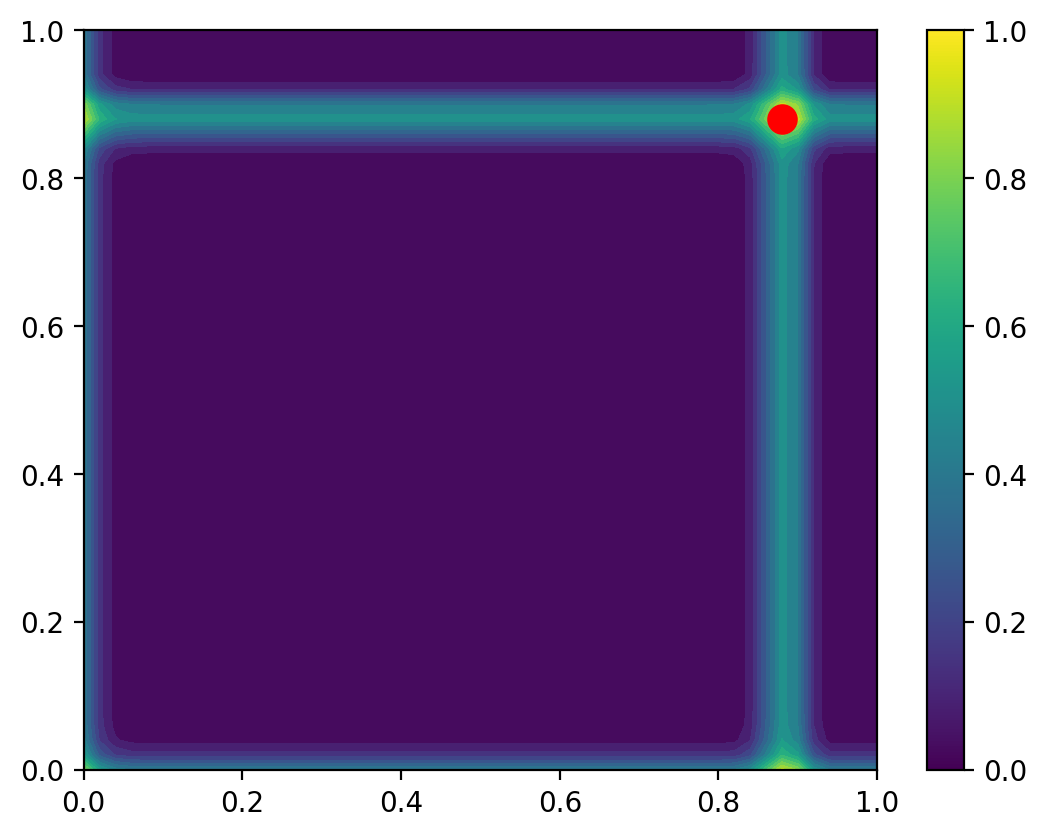

In [987]:
plt.contourf(*xtest_grid, ei_grid, levels=20)
plt.scatter(*x_next, c="red", s=100)
plt.colorbar()

In [988]:
# Update GP
latent_dist = posterior(init_params, D_next)(xtest)
predictive_dist = likelihood(init_params, latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

Text(0.5, 1.0, 'Posterior predictive — GP')

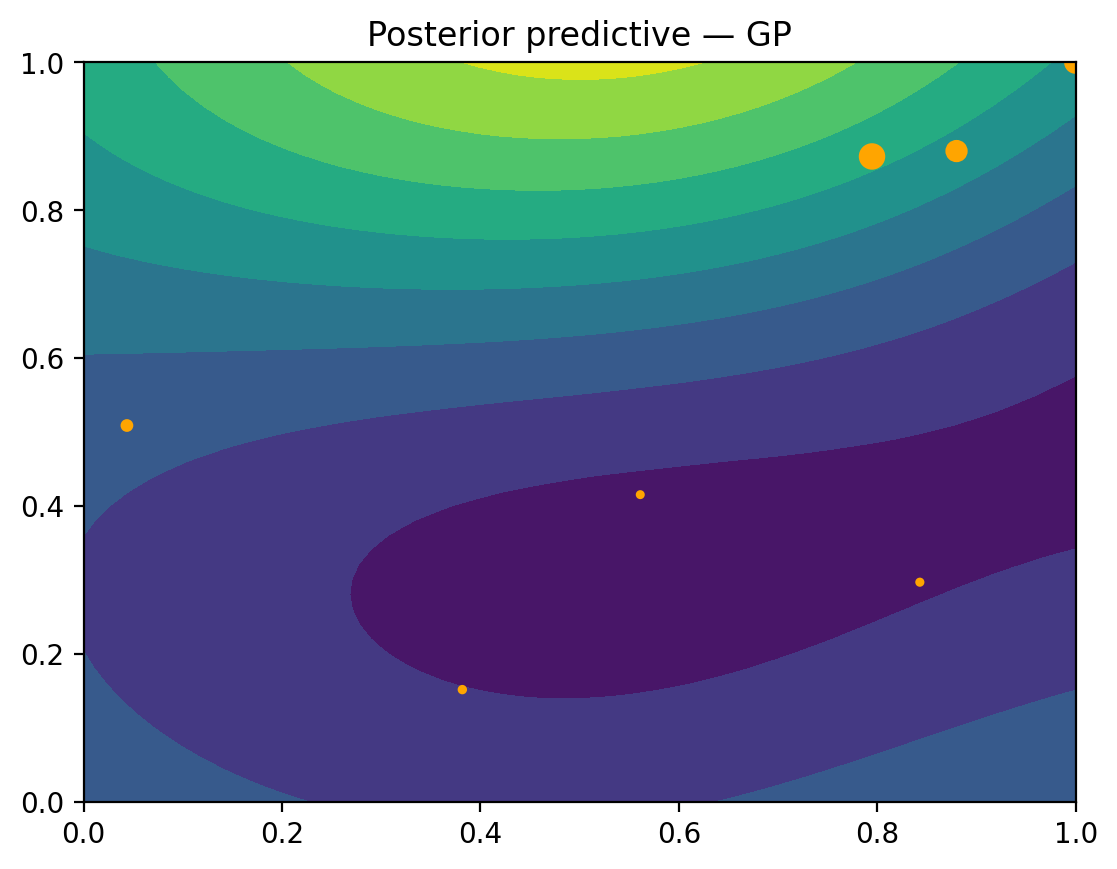

In [989]:
pm_grid = einops.rearrange(predictive_mean, "(width height) -> width height", width=nd1)
plt.contourf(*xtest_grid, pm_grid)

size = 5 * jnp.exp(D_next.y - D_next.y.min())
plt.scatter(*D_next.X.T, s=size, c="orange")
plt.title("Posterior predictive — GP")

In [990]:
# Evaluate function over candidate points
ei_xtest = jax.vmap(expected_improvement, in_axes=(0, None, None))(xtest, D_next, init_params)
ei_grid = einops.rearrange(ei_xtest, "(width height) -> width height", width=nd1)

In [991]:
# Select index with maxium value
ix_max = ei_xtest.argmax()

# EI value
ei_xtest[ix_max]

# Position and function evaluation
x_next = xtest[ix_max]
y_next = branin(*x_next)

# Update dataset
x_new = jnp.concatenate([D_next.X, x_next[None]])
y_new = jnp.append(D_next.y.ravel(), y_next)[:, None]

D_next = Dataset(X=x_new, y=y_new)

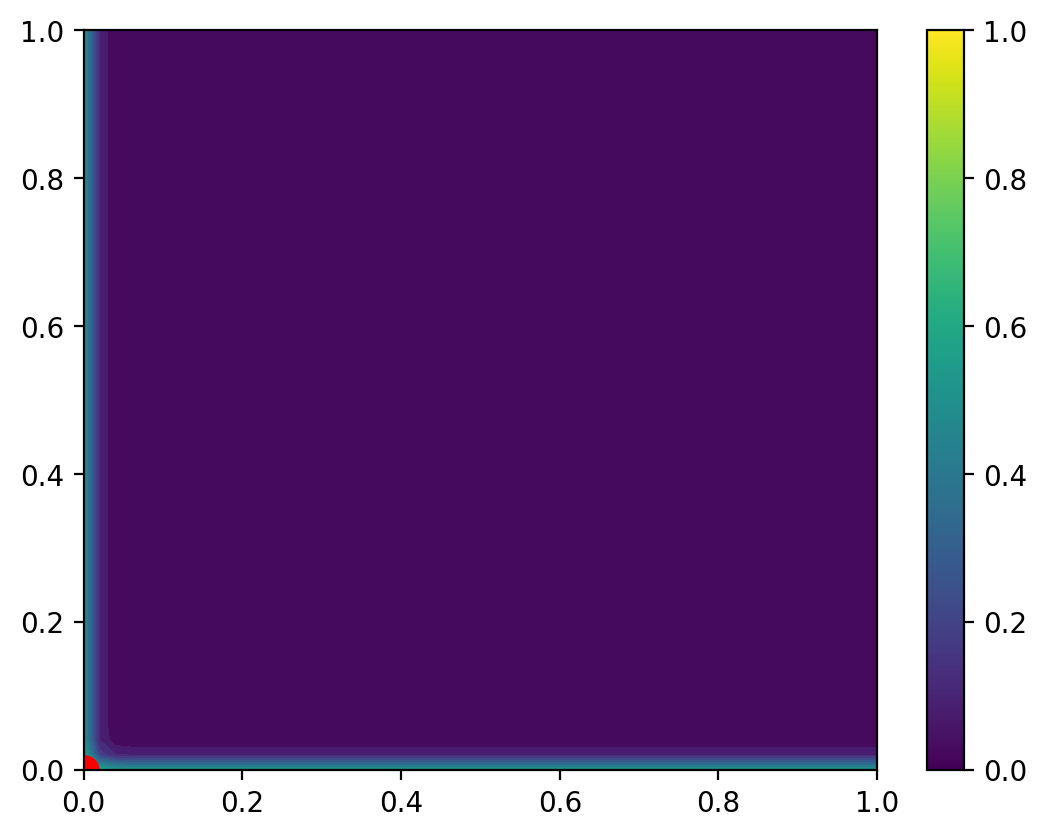

In [992]:
plt.contourf(*xtest_grid, ei_grid, levels=20)
plt.scatter(*x_next, c="red", s=100)
plt.colorbar()

In [993]:
# Update GP
latent_dist = posterior(init_params, D_next)(xtest)
predictive_dist = likelihood(init_params, latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

Text(0.5, 1.0, 'Posterior predictive — GP')

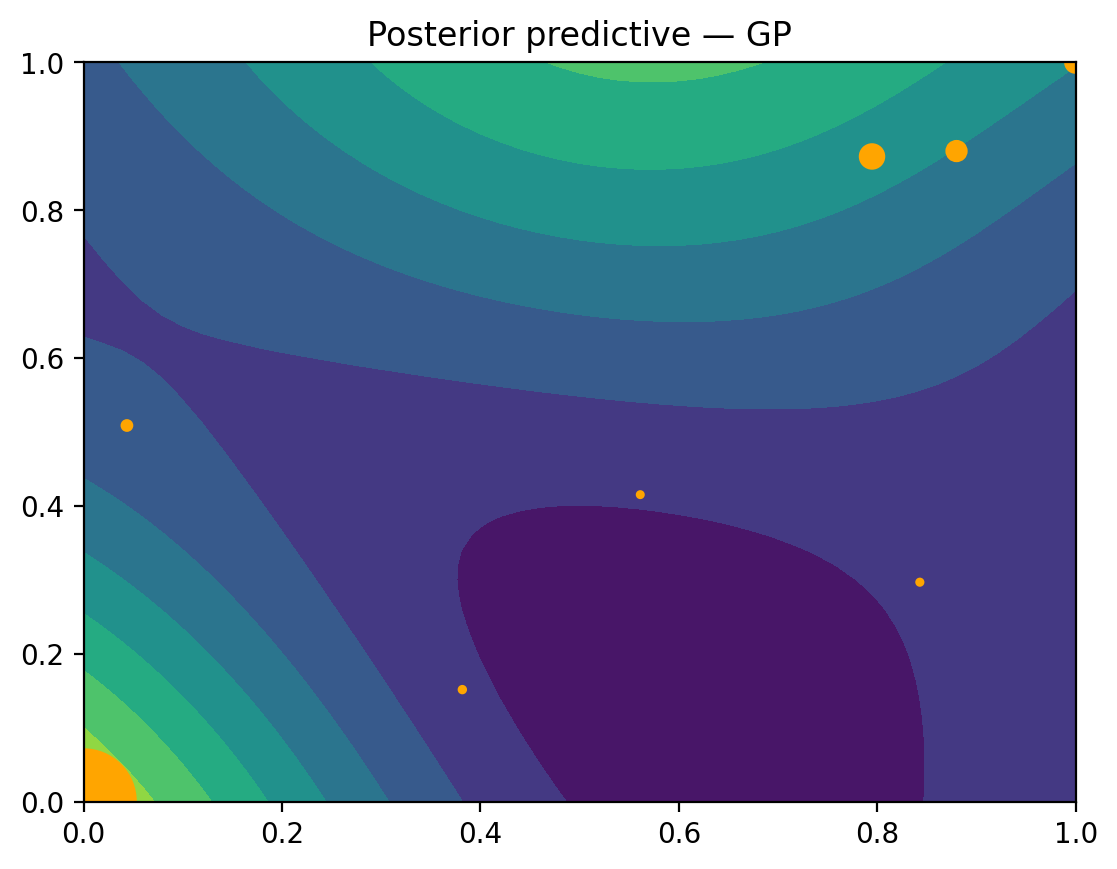

In [995]:
pm_grid = einops.rearrange(predictive_mean, "(width height) -> width height", width=nd1)
plt.contourf(*xtest_grid, pm_grid)

size = 5 * jnp.exp(D_next.y - D_next.y.min())
plt.scatter(*D_next.X.T, s=size, c="orange")
plt.title("Posterior predictive — GP")

In [996]:
# Evaluate function over candidate points
ei_xtest = jax.vmap(expected_improvement, in_axes=(0, None, None))(xtest, D_next, init_params)
ei_grid = einops.rearrange(ei_xtest, "(width height) -> width height", width=nd1)

In [997]:
# Select index with maxium value
ix_max = ei_xtest.argmax()

# EI value
ei_xtest[ix_max]

# Position and function evaluation
x_next = xtest[ix_max]
y_next = branin(*x_next)

# Update dataset
x_new = jnp.concatenate([D_next.X, x_next[None]])
y_new = jnp.append(D_next.y.ravel(), y_next)[:, None]

D_next = Dataset(X=x_new, y=y_new)

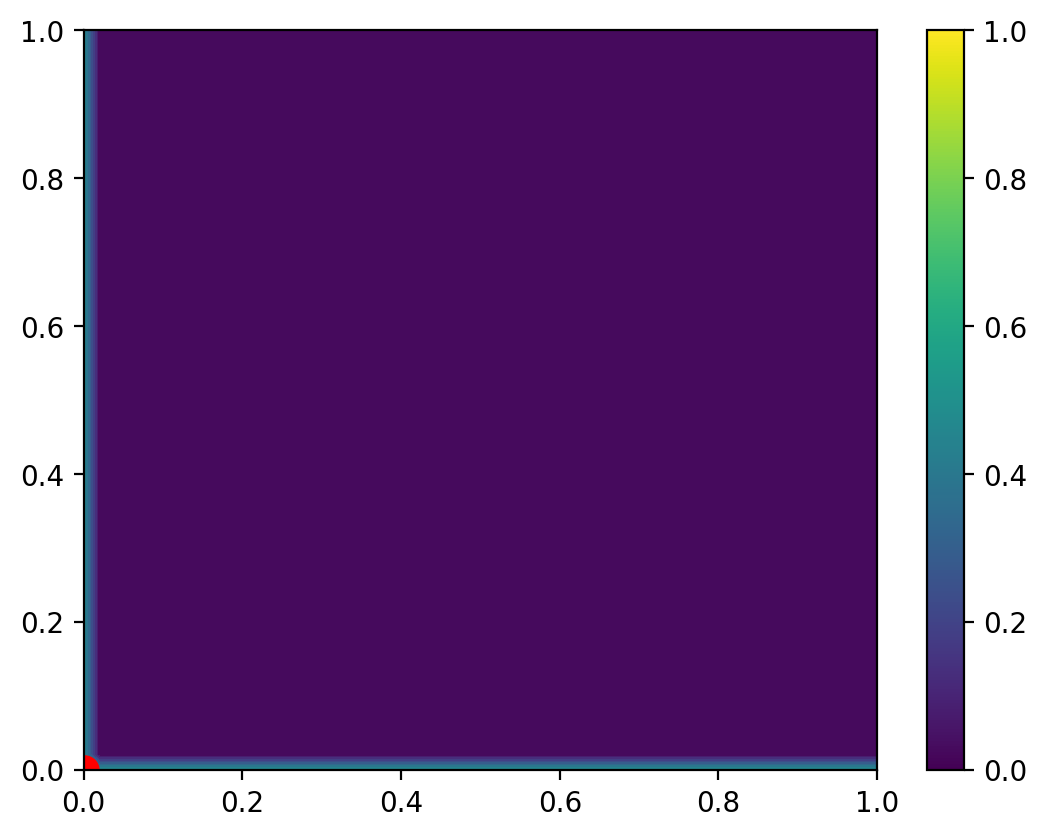

In [998]:
plt.contourf(*xtest_grid, ei_grid, levels=20)
plt.scatter(*x_next, c="red", s=100)
plt.colorbar()